get corpus from https://www.manythings.org/anki/ 

In [24]:
import os

input_lang = "eng"
target_lang = "spa"

if os.path.isfile(f"{input_lang}-{target_lang}.txt"):
    filepath = f"{input_lang}-{target_lang}.txt"
    reverse = False
elif os.path.isfile(f"{target_lang}-{input_lang}.txt"):
    filepath = f"{target_lang}-{input_lang}.txt"
    reverse = True
else:
    raise FileNotFoundError("Missing training set for specified language pair")

tokenize

In [25]:
import re, contractions
from torchtext.data.utils import get_tokenizer

tokenizer_eng = get_tokenizer("spacy", language="en_core_web_sm")
tokenizer_spa = get_tokenizer("spacy", language="es_core_news_sm")


def tokenize(text, lang=None):
    if lang == "eng":
        text = contractions.fix(text)
        tokenizer = tokenizer_eng
    elif lang == "spa":
        tokenizer = tokenizer_spa
    else:
        raise NotImplementedError("Missing tokenizer for specified language ")

    standardized_text = (
        text.replace("’", "'")
        .replace("‘", "'")
        .replace("´", "'")
        .replace("“", '"')
        .replace("”", '"')
        .replace("´´", '"')
    )
    tokens = tokenizer(standardized_text)
    filtered_tokens = [
        token
        for token in tokens
        if re.match(
            r"^[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+(-[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+)*(_[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+)*$",
            token,
            re.VERBOSE,
        )
    ]
    return filtered_tokens


#
#
#
#
# Example usage:
text_eng = "I'm building a translator!"
text_spa = "¡Estoy construyendo un traductor!"
print(tokenize(text_eng, lang="eng"))
print(tokenize(text_spa, lang="spa"))

['I', 'am', 'building', 'a', 'translator', '!']
['¡', 'Estoy', 'construyendo', 'un', 'traductor', '!']


define vocabularies from corpu as defined in next chapter

In [26]:
def corpus_iterator(filepath, lang, reverse):
    with open(filepath, "r", encoding="utf-8") as file:
        for line in file:
            elems = line.strip().split("\t")
            selected_text = elems[1 if reverse else 0]
            yield tokenize(selected_text, lang)

In [27]:
from torchtext.vocab import build_vocab_from_iterator


def build_vocab(filepath, lang, reverse, specials="<unk>", min_freq=5):
    vocab = build_vocab_from_iterator(
        corpus_iterator(filepath, lang, reverse),
        min_freq=min_freq,
        specials=specials,
    )
    vocab.set_default_index(vocab[specials[-1]])
    return vocab


special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]

vocab_input = build_vocab(filepath, input_lang, reverse, special_tokens)
vocab_target = build_vocab(filepath, target_lang, not reverse, special_tokens)

In [28]:
vocab_input.__len__()

6082

In [29]:
vocab_input.lookup_token(120)

'some'

preprocess data 

In [30]:
import numpy as np


def all_words_in_vocab(sentence, vocab):
    return all(word in vocab for word in sentence)


def pad_sentence(sequence, max_length=10):
    padding_length = max_length - len(sequence)
    return ["<sos>"] + sequence + ["<eos>"] + ["<pad>"] * padding_length


def process_corpus(
    lines,
    reverse,
    input_lang,
    target_lang,
    vocab_input,
    vocab_target,
    max_length=10,
):
    processed_inputs, processed_targets = [], []

    for line in lines:
        elems = line.strip().split("\t")

        input_seq = tokenize(elems[int(reverse)], input_lang)
        target_seq = tokenize(elems[int(not reverse)], target_lang)

        if (
            all_words_in_vocab(input_seq, vocab_input)
            and all_words_in_vocab(target_seq, vocab_target)
            and len(input_seq) <= max_length
            and len(target_seq) <= max_length
        ):
            padded_input = pad_sentence(input_seq)
            padded_target = pad_sentence(target_seq)

            processed_inputs.append(vocab_input(padded_input))
            processed_targets.append(vocab_target(padded_target))

    return np.array(processed_inputs), np.array(processed_targets)

datasets, dataloader

In [31]:
import deeptrack as dt
import torch
from torch.utils.data import DataLoader


with open(filepath, "r", encoding="utf-8") as file:
    inputs, targets = process_corpus(
        file, reverse, input_lang, target_lang, vocab_input, vocab_target
    )

sources = dt.sources.Source(inputs=inputs, targets=targets)
train_sources, test_sources = dt.sources.random_split(sources, [0.85, 0.15])

inputs_pl = dt.Value(sources.inputs) >> dt.pytorch.ToTensor(dtype=torch.int)
targets_pl = dt.Value(sources.targets) >> dt.pytorch.ToTensor(dtype=torch.int)


from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(
    inputs_pl & targets_pl,
    inputs=train_sources
)

test_dataset = dt.pytorch.Dataset(
    inputs_pl & targets_pl,
    inputs=test_sources
)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [32]:
import numpy as np

print(f"Number of queries/responses: {len(inputs)}")

Number of queries/responses: 91183


encoder

In [33]:
from deeplay import DeeplayModule
import torch


class Seq2SeqEncoder(DeeplayModule):

    def __init__(
        self,
        vocab_size,
        in_features = 300,
        hidden_features = 128,
        hidden_layers = 1,
        dropout = 0.0,
        rnn_type= "GRU",
        bidirectional=True,
    ):
        super().__init__()
        if isinstance(rnn_type, type) and issubclass(rnn_type, torch.nn.Module):
            self.rnn_class = rnn_type
        elif rnn_type == "LSTM":
            self.rnn_class = torch.nn.LSTM
        elif rnn_type == "GRU":
            self.rnn_class = torch.nn.GRU
        else:
            self.rnn_class = torch.nn.RNN

        self.hidden_features = hidden_features
        self.hidden_layers = hidden_layers
        self.bidirectional = bidirectional
        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_features)
        self.rnn = dl.Layer(
            self.rnn_class,
            input_size=in_features,
            hidden_size=hidden_features,
            num_layers=hidden_layers,
            dropout=(0 if hidden_layers == 1 else dropout),
            bidirectional=bidirectional,
            batch_first=True,
        )

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        outputs, hidden = self.rnn(x, hidden)
        if self.bidirectional:
            outputs = (
                outputs[:, :, : self.hidden_features]
                + outputs[:, :, self.hidden_features :]
            )
            hidden = hidden[: self.hidden_layers]
        return outputs, hidden

decoder

In [34]:
class Seq2SeqDecoder(DeeplayModule):

    def __init__(
        self,
        vocab_size,
        in_features = 300,
        hidden_features = 128,
        hidden_layers = 1,
        dropout = 0.0,
        rnn_type= "GRU",
        attn = None,  #####
    ):
        super().__init__()
        if isinstance(rnn_type, type) and issubclass(rnn_type, torch.nn.Module):
            self.rnn_class = rnn_type
        elif rnn_type == "LSTM":
            self.rnn_class = torch.nn.LSTM
        elif rnn_type == "GRU":
            self.rnn_class = torch.nn.GRU
        else:
            self.rnn_class = torch.nn.RNN

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_layers = hidden_layers
        self.attn = attn  #####
        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_features)
        self.rnn = dl.Layer(
            self.rnn_class,
            input_size=(
                in_features + hidden_features if attn is not None else in_features
            ),  #####
            hidden_size=hidden_features,
            num_layers=hidden_layers,
            bidirectional=False,
            batch_first=True,
            dropout=(0 if hidden_layers == 1 else dropout),
        )
        self.dense = dl.Layer(torch.nn.Linear, hidden_features, vocab_size)
        self.softmax = dl.Layer(torch.nn.Softmax, dim=-1)
        self.relu = dl.Layer(torch.nn.ReLU)

    def forward(self, x, hidden, encoder_outputs):  #####
        x = self.embedding(x) ##### from
        if self.attn:  
            query = hidden[-1:, :, :].permute(1, 0, 2)
            context, attn_weights = self.attn(query, encoder_outputs)
            x = torch.cat((x, context), dim=2)
        else:
            x = self.relu(x)
            attn_weights = []  ##### to
        output, hidden = self.rnn(x, hidden)
        output = self.dense(output)
        output = self.softmax(output)
        return output, hidden, attn_weights  ###

seq2seq

In [35]:
class Seq2SeqModel(DeeplayModule):

    def __init__(
        self,
        in_vocab_size,
        out_vocab_size,
        teacher_prob=1.0,
        embedding_dim = 300,
        hidden_features = 128,
        hidden_layers = 1,
        dropout = 0.0,
        rnn_type = "GRU",
        bidirectional=True,
        attn = None,  #####
    ):
        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.teacher_prob = teacher_prob
        self.attn = attn  #####
        self.encoder = Seq2SeqEncoder(
            in_vocab_size,
            embedding_dim,
            hidden_features,
            hidden_layers,
            dropout,
            rnn_type,
            bidirectional,
        )
        self.decoder = Seq2SeqDecoder(
            out_vocab_size,
            embedding_dim,
            hidden_features,
            hidden_layers,
            dropout,
            rnn_type,
            attn,  #####
        )

    def forward(self, x):
        input, target = x
        encoder_outputs, encoder_hidden = self.encoder(input)
        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(
            (
                target.size(0),
                target.size(1),
                self.out_vocab_size,
            )
        ).to(next(self.encoder.parameters()).device)

        for t in range(input.size(1)):
            if t == 0 or np.random.rand() < self.teacher_prob:
                decoder_input = target[:, t].unsqueeze(-1)
            else:
                decoder_input = topi.squeeze(-1).detach()

            decoder_input = decoder_input.to(next(self.decoder.parameters()).device)

            decoder_output, decoder_hidden, _ = self.decoder(  #####
                decoder_input,
                decoder_hidden,
                encoder_outputs,  #####
            )

            _, topi = decoder_output.topk(1)
            decoder_outputs[:, t, :] = decoder_output.squeeze(1)

        return decoder_outputs  # , decoder_hidden  ##### CARLO

    def evaluate(self, x):
        if isinstance(x, (list, tuple)):
            input = x[0]
        else:
            input = x

        with torch.no_grad():
            encoder_outputs, encoder_hidden = self.encoder(input)
        decoder_hidden = encoder_hidden
        outputs = torch.zeros(
            input.shape,
        ).to(next(self.encoder.parameters()).device)
        attentions = []  #####
        for t in range(input.size(1)):
            if t == 0:
                decoder_input = torch.full(
                    size=(input.size(0), 1),
                    fill_value=1,
                    device=next(self.encoder.parameters()).device,
                )
            else:
                decoder_input = topi.squeeze(-1).detach()

            decoder_input = decoder_input.to(next(self.decoder.parameters()).device)
            with torch.no_grad():
                decoder_output, decoder_hidden, attn_weights = self.decoder(  #####
                    decoder_input,
                    decoder_hidden,
                    encoder_outputs,  #####
                )
                attentions.append(attn_weights)  #####
            _, topi = decoder_output.topk(1)
            outputs[:, t] = topi.squeeze()

        return outputs, attentions  #####

loss

In [36]:
def maskedNLL(inp, target, PADtoken=0):
    mask = target != PADtoken
    NLL = -torch.log(torch.gather(inp.view(-1, inp.shape[-1]), 1, target.view(-1, 1)))
    loss = NLL.masked_select(mask.view(-1, 1)).mean()
    return loss

application

In [37]:
from deeplay import Application, Optimizer
# import torchmetrics as tm


class Seq2Seq(Application):

    def __init__(
        self,
        in_vocab,
        out_vocab,
        teacher_prob=1.0,
        model=None,
        optimizer=None,
        loss=None,
        attn = None,  #####
    ):

        in_vocab_size = len(in_vocab)
        out_vocab_size = len(out_vocab)

        self.model = model or Seq2SeqModel(
            in_vocab_size=in_vocab_size,
            out_vocab_size=out_vocab_size,
            teacher_prob=teacher_prob,
            attn=attn,  #####
        )

        self.in_vocab_size = in_vocab_size
        self.out_vocab_size = out_vocab_size
        self.teacher_prob = teacher_prob
        self.optimizer = optimizer or dl.Adam(lr=1e-3)
        self.loss = loss or maskedNLL
        self.out_vocab = out_vocab

        @self.optimizer.params
        def params(self):
            return self.parameters()

        super().__init__(loss=loss)

    def train_preprocess(self, batch):
        x = batch
        y = torch.cat((x[-1][:, 1:], x[-1][:, -1:]), dim=1)
        return x, y

    val_preprocess = train_preprocess
    test_preprocess = train_preprocess

    def forward(self, x):
        decoder_outputs = self.model(x)  ##### #, decoder_hidden CARLO

        return decoder_outputs

embeddings

In [38]:
from torchtext.vocab import GloVe

embedding_dim = 300

glove = GloVe(name="42B", dim=embedding_dim, cache="./.vector_cache")

glove_embeddings_input = glove.get_vecs_by_tokens(
    vocab_input.get_itos(), lower_case_backup=True
)
glove_embeddings_target = glove.get_vecs_by_tokens(
    vocab_target.get_itos(), lower_case_backup=True
)

num_special_tokens = len(special_tokens)
glove_embeddings_input[1:num_special_tokens] = (
    torch.rand(num_special_tokens - 1, embedding_dim) * 0.01
)  

glove_embeddings_target[1:num_special_tokens] = (
    torch.rand(num_special_tokens - 1, embedding_dim) * 0.01
) 

INFO:torchtext.vocab.vectors:Loading vectors from ./.vector_cache/glove.42B.300d.txt.pt


attentions

In [39]:
class DotProductAttention(DeeplayModule):

    def __init__(self):
        super().__init__()
        self.act = dl.Layer(torch.nn.Softmax, dim=-1)

    def forward(self, query, keys):
        scores = torch.sum(query * keys, dim=2).unsqueeze(1)
        weights = self.act(scores)
        context = torch.bmm(weights, keys)

        return context, weights

In [40]:
class AdditiveAttention(DeeplayModule):

    def __init__(self, in_features=128, emb_dim=300):
        super().__init__()
        self.Wa = dl.Layer(torch.nn.Linear, in_features, emb_dim)
        self.Ua = dl.Layer(torch.nn.Linear, in_features, emb_dim)
        self.Va = dl.Layer(torch.nn.Linear, emb_dim, 1)
        self.act = dl.Layer(torch.nn.Softmax, dim=-1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = self.act(scores)
        context = torch.bmm(weights, keys)

        return context, weights

model (select the kind of attention you want to use)

In [41]:
import deeplay as dl

#attn = DotProductAttention()
attn = AdditiveAttention()

seq2seq = Seq2Seq(
    in_vocab=vocab_input,
    out_vocab=vocab_target,
    teacher_prob=0.85,
    attn=attn,
)

seq2seq = seq2seq.create()

In [42]:
seq2seq.model.encoder.embedding.weight.data = glove_embeddings_input
seq2seq.model.encoder.embedding.weight.requires_grad = False
seq2seq.model.decoder.embedding.weight.data = glove_embeddings_target
seq2seq.model.decoder.embedding.weight.requires_grad = False

In [43]:
trainer = dl.Trainer(max_epochs=25, accelerator="auto")
trainer.fit(seq2seq, train_loader)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ Seq2SeqModel     │  6.4 M │
│ 1 │ out_vocab     │ Vocab            │      0 │
│ 2 │ train_metrics │ MetricCollection │      0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 4.6 M                                                                                        
Total params: 6.4 M                                                                                                
Total estimated model params size (MB): 25

Output()

(<Figure size 1500x500 with 1 Axes>,
 array([[<Axes: title={'center': 'Loss'}, xlabel='Step'>]], dtype=object))

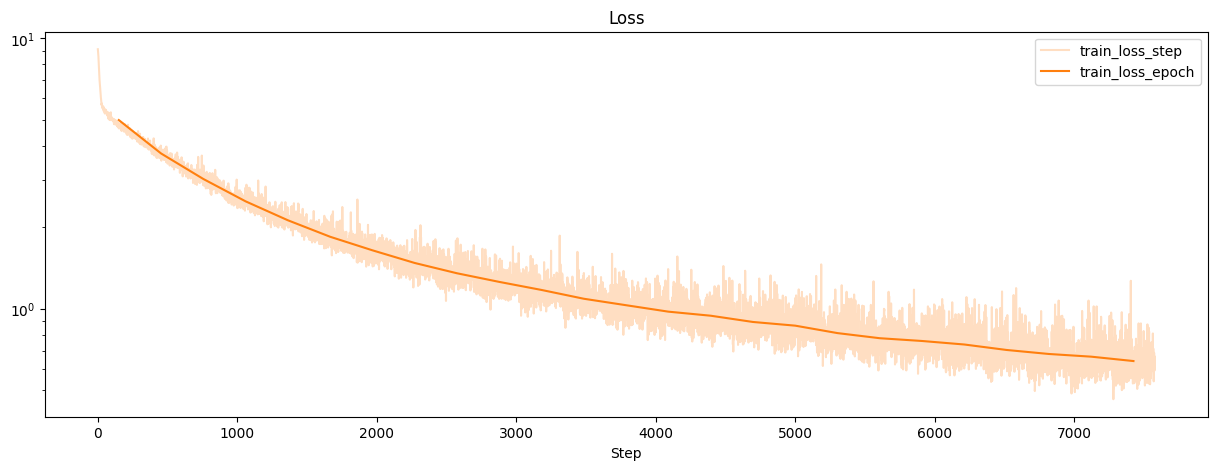

In [44]:
trainer.history.plot()

evaluate results

In [45]:
def unprocess(x, vocab):
    unproc = []
    for s in x:
        idxs = s[s > 2]
        current_words = [vocab.lookup_token(idx) for idx in idxs]
        unproc.append(" ".join(current_words))

    return unproc

In [46]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator


def translate_and_display_attn(
    source_text,
    model,
    input_lang,
    vocab_input,
    vocab_target,
):
    query_tokens = tokenize(source_text, input_lang)
    query_tokens = pad_sentence(query_tokens)
    query_indices = vocab_input(query_tokens)
    if 3 in query_indices:
        print(
            "Warning: Unknown word(s) found in the input text. They were replaced by the placeholder token."
        )

    source_sequence = torch.tensor(query_indices, dtype=torch.int).unsqueeze(0)

    source_sequence = source_sequence.to(next(model.parameters()).device)
    y_hat, attns = model.evaluate(source_sequence)  #####

    y_hat_un = [vocab_target.lookup_token(y) for y in y_hat.squeeze()]

    att = torch.cat(attns, dim=1).squeeze()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(att, cmap="bone")
    fig.colorbar(cax)

    ax.set_xticklabels(
        [""] + query_tokens, rotation=90
    )
    ax.set_yticklabels([""] + y_hat_un)

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))

    plt.show()

    translated_text = unprocess(y_hat, vocab_target)
    print(f"\nInput Sentence: {source_text}")
    print(f"Predicted Translation: {translated_text[0]}")

/var/folders/m1/pc2jmjl93c7chdf35rtyxdg0h6sh_6/T/ipykernel_9509/782198433.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/var/folders/m1/pc2jmjl93c7chdf35rtyxdg0h6sh_6/T/ipykernel_9509/782198433.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + y_hat_un)


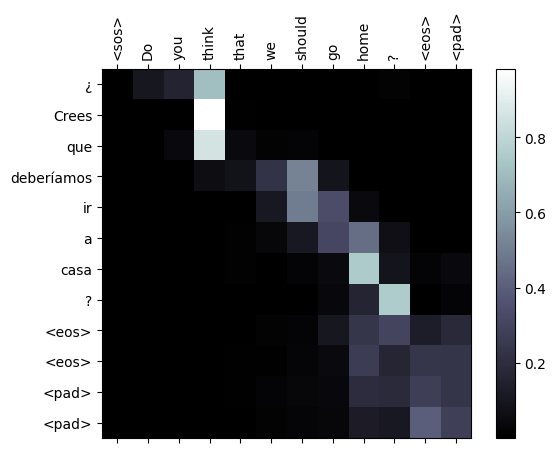


Input Sentence: Do you think that we should go home?
Predicted Translation: ¿ Crees que deberíamos ir a casa ?


In [49]:
source_text = "Do you think that we should go home?"
translate_and_display_attn(source_text,seq2seq.model,input_lang, vocab_input,vocab_target)

/var/folders/m1/pc2jmjl93c7chdf35rtyxdg0h6sh_6/T/ipykernel_9509/782198433.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/var/folders/m1/pc2jmjl93c7chdf35rtyxdg0h6sh_6/T/ipykernel_9509/782198433.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + y_hat_un)


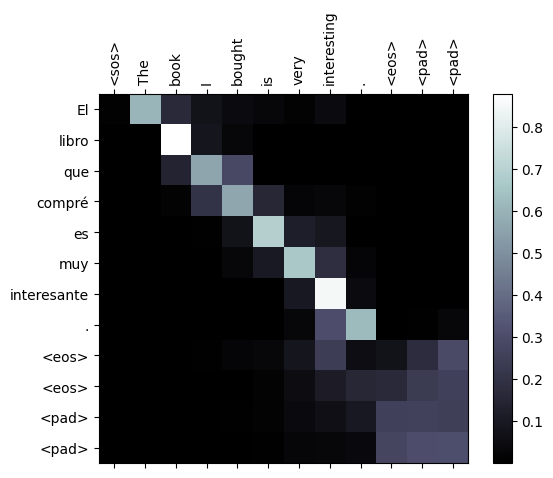


Input Sentence: The book I bought is very interesting.
Predicted Translation: El libro que compré es muy interesante .


In [54]:
source_text = "The book I bought is very interesting."
translate_and_display_attn(source_text,seq2seq.model,input_lang, vocab_input,vocab_target)

calculate BLEU score

In [52]:
from torchmetrics.text import BLEUScore

bleu_score = BLEUScore()

In [53]:
# device = "cpu"
# seq2seq.model.to(device)
device = next(seq2seq.model.parameters()).device

for batch_index, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    y_hat, _ = seq2seq.model.evaluate((inputs, targets))  #####

    input_un = unprocess(inputs, vocab_input)
    y_hat_un = unprocess(y_hat, vocab_target)
    target_un = unprocess(targets, vocab_target)
    y = [[yi] for yi in target_un]

    bleu_score.update(y_hat_un, y)

    if batch_index < 3:
        print(f"\nExamples from batch {batch_index + 1}:")
        for i in range(min(3, len(input_un))):
            print(f"\nInput Sentence: {input_un[i]}")
            print(f"Predicted Translation: {y_hat_un[i]}")
            print(f"Actual Translation: {target_un[i]}")

final_bleu = bleu_score.compute()
print(f"\nValidation BLEU Score: {final_bleu:.3f}")


Examples from batch 1:

Input Sentence: The old man spoke with me in French .
Predicted Translation: El anciano habló conmigo francés .
Actual Translation: El anciano me habló en francés .

Input Sentence: Tell me it is not true .
Predicted Translation: Dime que no es verdad .
Actual Translation: Decime que no es verdad .

Input Sentence: He got off to a flying start .
Predicted Translation: Él se puso a volar un un domingo .
Actual Translation: Empezó con mucho impulso .

Examples from batch 2:

Input Sentence: She is Tom younger sister .
Predicted Translation: Ella es la hermana menor de Tom .
Actual Translation: Ella es la hermana menor de Tom .

Input Sentence: You may not have heard about this .
Predicted Translation: Puede que no has oído de esto .
Actual Translation: Puede que no hayas escuchado hablar sobre esto .

Input Sentence: What did you say ?
Predicted Translation: ¿ Qué dijo ?
Actual Translation: ¿ Qué has dicho ?

Examples from batch 3:

Input Sentence: Tom , Mary and

try on a few new sentences